# Introduction

This Jupyter Notebook has the objective to create a Neural Network model that can predict if the person has diabetes.

## Libraries used

For this challenge I have used:

- tensorflow
- keras
- numpy
- pandas
- scikit-learn
- scikit-plot

# The code!

## Importing the dataset

To begin let's import the dataset into a panda's dataframe and creating the X and y tables.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf

RS=0

tf.random.set_seed(seed=RS)

df = pd.read_csv("diabetes.csv")

# df = df[(df['BloodPressure']!=0) & (df['SkinThickness']!=0) & (df['BMI']!=0)]
print(df.groupby(['Outcome']).count())

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

         Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
Outcome                                                                     
0                500      500            500            500      500  500   
1                268      268            268            268      268  268   

         DiabetesPedigreeFunction  Age  
Outcome                                 
0                             500  500  
1                             268  268  


## Formatting the data

This part is one of the most important parts, that's because neural networks works better with values between 0 and 1. So we will format the data.

But before that let's take a look at the details of the dataframe:

In [2]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


So every feature has values above 1 and that's a problem, so let's format it:

In [3]:
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

X.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.63953,0.847771,0.149543,0.906679,-0.692439,0.20388,0.468187,1.425067


Now all values are between 0 and 1 and we can start making our model.

## Making the structure model

Now we can create the structure of the neural network, in this example we will use the following structure:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(8, input_dim=8, activation="relu"),
#     Dropout(rate=0.1),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(8, activation="relu"),

    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

Above you can se more details about the structure...

A Dropout function has been used so we pick random neurons of the layer that comes after it has been called.

## Splitting the data

To train the model we need to split the data so we can get a better result.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=RS)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, test_size=0.3, random_state=RS)

Now that we have the trainning and validation data we can train it.

## Training the model

To train the data we will use WarlyStopping function that will stop the training as soon as the overfitting starts.

<AxesSubplot:>

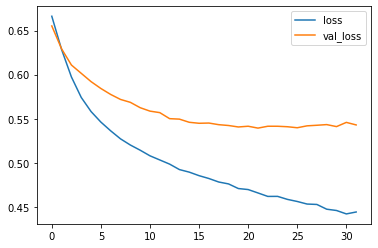

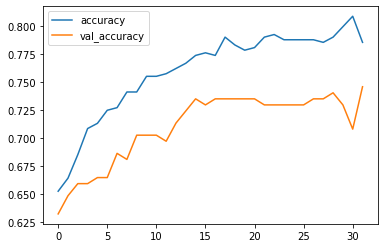

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.00005,
    restore_best_weights=True,
)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)

history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

By seeing this graphics we can be sure that there is almost no overfitting, and we have trained enough so we have passed the underfitting phase.

## Predicting diabetes

Let's predict using the validation data:

In [7]:
preds = model.predict(X_test)
for pred in preds:
    if pred[0] >= 0.5:
        pred[0] = 1
    else:
        pred[0] = 0

After the prediction you will have an array with values between 0 and 1 so we need to get values above of 0.5 and consider they are 1 and lower than 0.5 we change to 0. That way we can plot a confusion matrix :)

## Checking the predictions

Accuracy: 75.63%
Precision: 64.0%
Recall: 68.09%
F1 score: 65.98%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

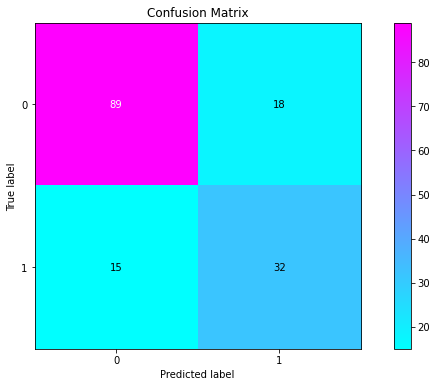

In [8]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
import scikitplot as skplt

print("Accuracy: " + str(round(balanced_accuracy_score(y_test, preds)*100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_test, preds, average='binary')*100, 2)) + "%")
print("Recall: " + str(round(recall_score(y_test, preds, average='binary')*100, 2)) + "%")
print("F1 score: " + str(round(f1_score(y_test, preds, average='binary')*100, 2)) + "%")

skplt.metrics.plot_confusion_matrix(
    y_test,
    preds,
    figsize=(12,6),
    cmap="cool",
)

Confusion matrix is a great way to display the results, because it shows our True Positives and Negatives and the False Positives and Negatives.